![Aeropython Logo](/files/imagenes/aeropython_logo.png)

#-- Este ejercicio está en construcción --

#Resolviendo un Laberinto

El problema es muy sencillo: tenemos un laberinto, y deseamos que nuestro algoritmo genético encuentre la salida

Empecemos importando los paquetes necesarios y creando el laberinto:

In [1]:
%matplotlib inline
import laberinto.algen as ag
import laberinto as lab
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mapa1 = lab.Map()

Pintemos el laberinto!

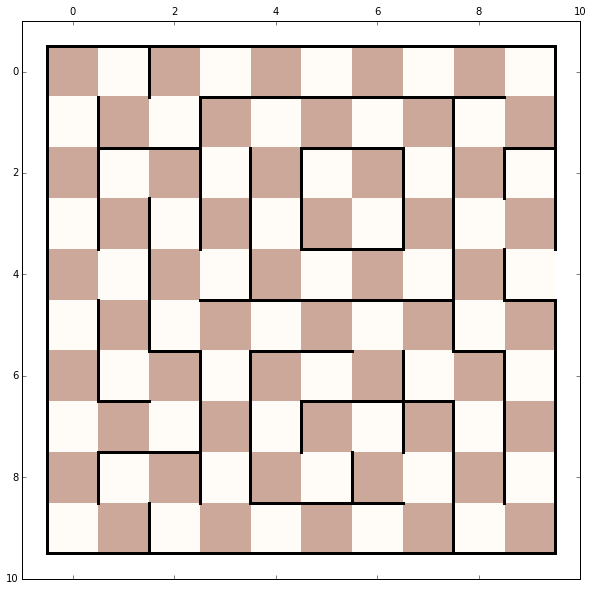

In [3]:
mapa1.draw_tablero()

Queda chulo, ¿verdad?

## Creando un camino a partir de un genoma

Ahora viene una cuestión interesante: ¿Cómo definimos un camino a partir de un genoma?

Existen varias maneras, pero probablemente la mas simple sea esta:

Para cada casilla, el genoma nos designa una dirección, en la que un viajero intentaría moverse una vez que ha llegado a esa casilla.

Veamos cómo quedaría:

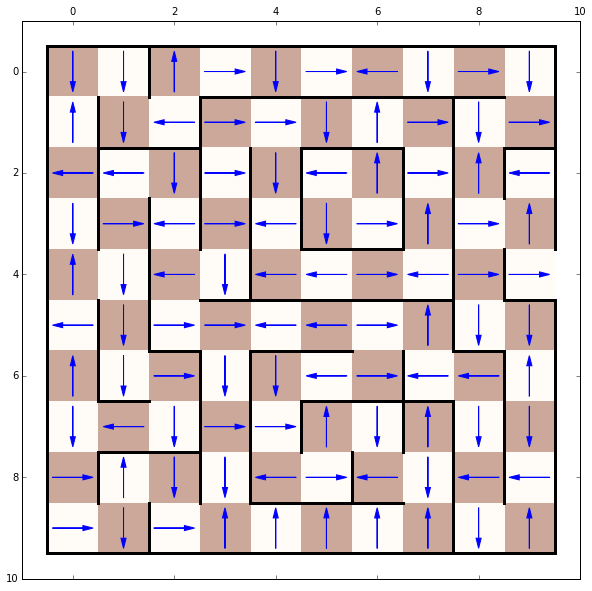

In [4]:
mapa1.create_camino()
ejemplo = mapa1.list_caminos[0]
ag.calculate_traits(ejemplo, ejemplo.dict_genes)
lab.calculate_performances(ejemplo)
ejemplo.draw_directions()

Un viajero que intentara seguir estas indicaciones, estaría en un buen apuro. ¡Incluso algunas flechas apuntan a las paredes! Necesitaremos ser un poco flexibles para recorrerlo:


- Si la dirección de la casilla le dice que intente atravesar una pared, el viajero intentará otra dirección aleatoria.

- El viajero tendrá una cantidad limitada de pasos.

Probémoslo!

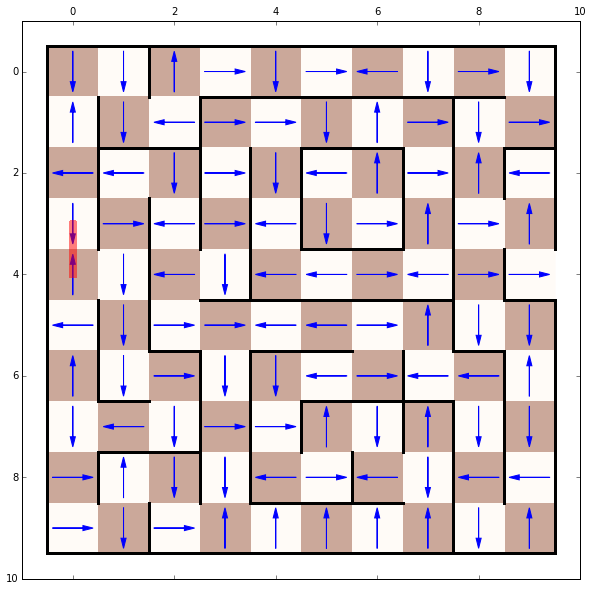

In [5]:
ejemplo.draw_directions()
ejemplo.draw_path()

##Implementando el algoritmo genético

...La verdad es que como camino, no es gran cosa...

Pero no es suficiente con decir que es "malo", tenemos que ir más allá: tenemos que evaluar el camino objetivamente con una serie de reglas para poder usar el algoritmo genético:

- Cuando el viajero choque con una pared, el camino recibirá una pequeña penalización.

- Si hay dos casillas que se apuntan mutuamente, el viajero quedará atrapado, por lo que también penalizamos volver a la casilla de la que se partió en el turno anterior.

- Queremos llegar a la salida de la derecha, por lo que beneficiaremos a los caminos que dejen al viajero más a la derecha.

- Si un camino conduce a la salida, le daremos una gran bonificación para no perderlo

¡Probemos con estas reglas un algoritmo genético!

In [6]:
lab.calculate_fitness(ejemplo)
ejemplo.fitness

-147.0

Ya tenemos un valor numérico, lancemos el algoritmo!

1·2·3·4·5·6·7·8·9·10·11·12·13·14·15·16·17·18·19·20·21·22·23·24·25·26·27·28·29·30·31·32·33·34·35·36·37·38·39·40·41·42·43·44·45·46·47·48·49·50·51·52·53·54·55·56·57·58·59·60·61·62·63·64·65·66·67·68·69·70·71·72·73·74·75·76·77·78·79·80·81·82·83·84·85·86·87·88·89·90·91·92·93·94·95·96·97·98·99·100·

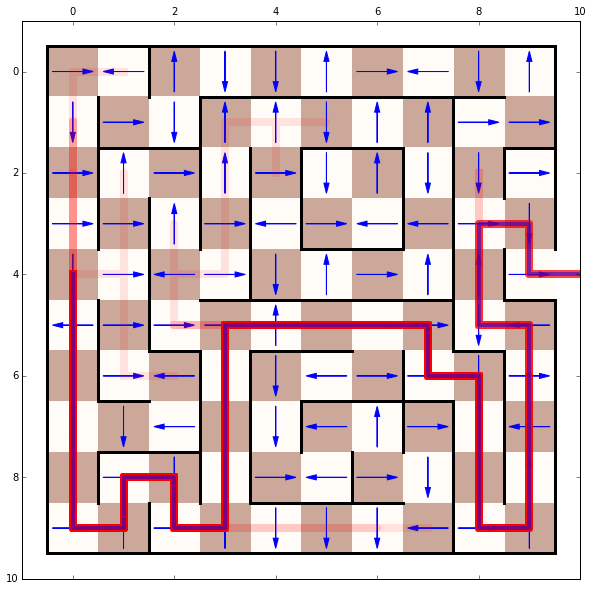

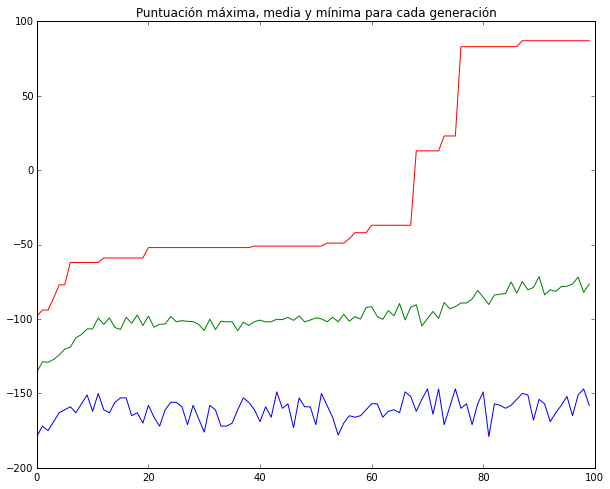

In [7]:
lab.avanzar(mapa1)
lab.draw_all(mapa1)

##Resultados

Llegados a este punto, lo más probable es que el algoritmo haya encontrado un bucle o una salida. Si no, puedes volver a ejecutar la celda superior para avanzar unas generaciones más.

Todos los caminos de la última generación están representados como líneas rojas semitransparentes, de modo que las casillas más atravesadas van acumulando capas de rojo. Además, el mejor camino encontrado se muestra destacado en azul.

También puedes correr el algoritmo desde el principio si añades *"mapa1 = lab.Map()"* antes de *"lab.avanzar(mapa1)"*.

Si pruebas a ejecutarlo varias veces, observarás lo antes comentado, cuando alcanza la salida, todo genial, pero si llega a un bucle, ¿Qué podemos hacer para sacarlo de ahí?

La respuesta es, *obviamente*, añadir **Neurotoxinas Letales** al laberinto. Pero no de cualquier manera!

##Añadiendo Feedback

Supongamos que cada persona que va recorriendo el laberinto a dejando a su paso un olor fétido que hace que todos los demás prefieran no tener que pasar por allí. ¿Cómo crees que eso afectaría a los bucles?

La manera de implementar este efecto es añadir al mapa una capa de profundidad, una matriz adicional que expresa la cantidad de veneno, feromona negativa o mal olor que hay en cada casilla. Después, al analizar nuestro camino, contaremos también la cantidad de veneno que hemos atravesado para puntuar la calidad del camino dentro del algoritmo.

Comprobémoslo!

Ejecuta de nuevo el algoritmo, pero ahora añadiendo veneno. Ejecútalo varias veces! ¿Aparecen bucles con la misma frecuencia?

1·2·3·4·5·6·7·8·9·10·11·12·13·14·15·16·17·18·19·20·21·22·23·24·25·26·27·28·29·30·31·32·33·34·35·36·37·38·39·40·41·42·43·44·45·46·47·48·49·50·51·52·53·54·55·56·57·58·59·60·61·62·63·64·65·66·67·68·69·70·71·72·73·74·75·76·77·78·79·80·81·82·83·84·85·86·87·88·89·90·91·92·93·94·95·96·97·98·99·100·

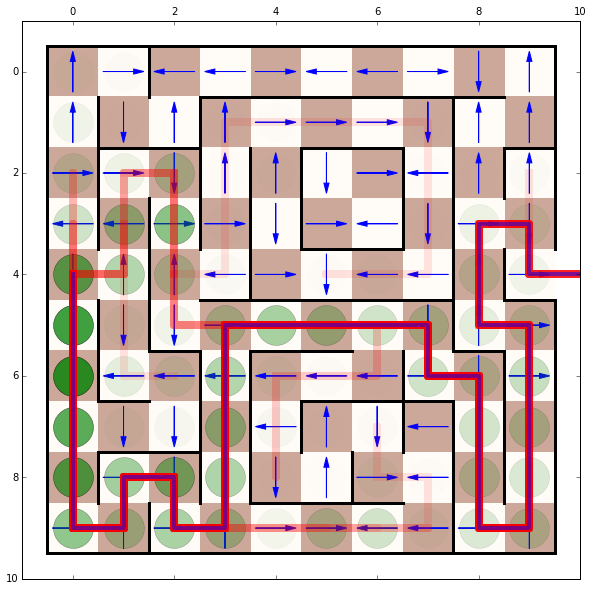

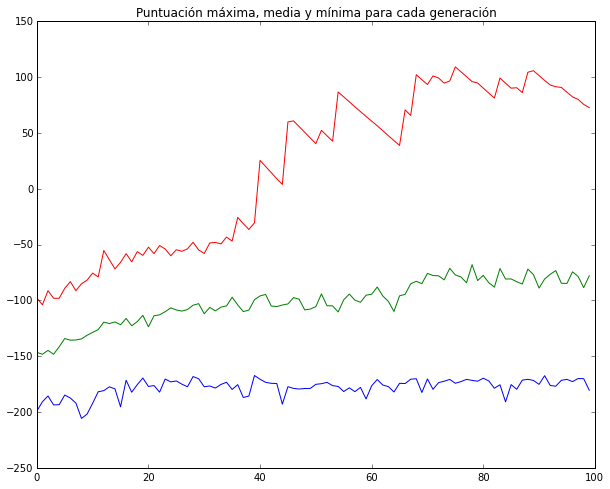

In [8]:
mapa2 = lab.Map(veneno=1)
lab.avanzar(mapa2)
lab.draw_all(mapa2)

Sin embargo, abusar de las neurotoxinas letales también puede tener problemas, ¡Quién lo hubiera adivinado!

¡Prueba con la configuración siguiente!

1·2·3·4·5·6·7·8·9·10·11·12·13·14·15·16·17·18·19·20·21·22·23·24·25·26·27·28·29·30·31·32·33·34·35·36·37·38·39·40·41·42·43·44·45·46·47·48·49·50·51·52·53·54·55·56·57·58·59·60·61·62·63·64·65·66·67·68·69·70·71·72·73·74·75·76·77·78·79·80·81·82·83·84·85·86·87·88·89·90·91·92·93·94·95·96·97·98·99·100·

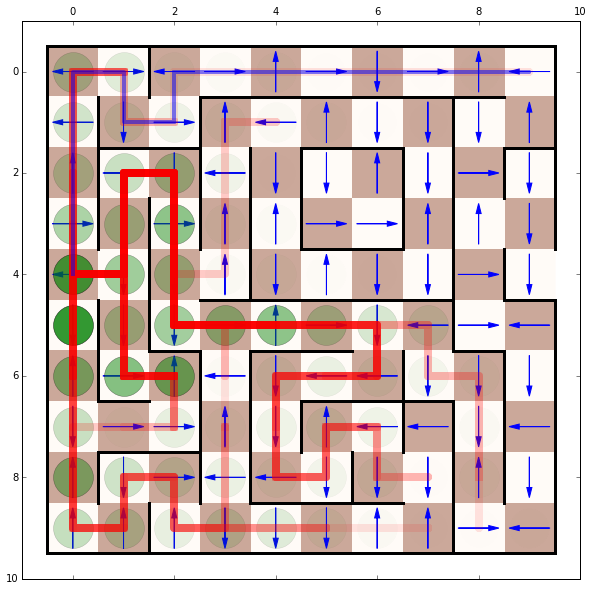

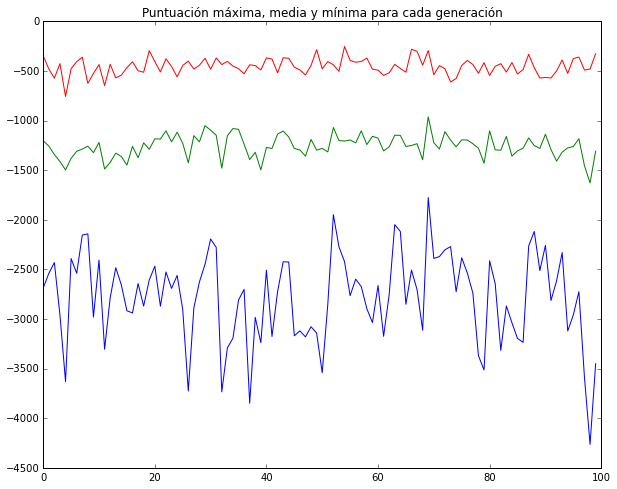

In [9]:
mapa2 = lab.Map(veneno=100)
lab.avanzar(mapa2)
lab.draw_all(mapa2)

Si te interesa investigar más este efecto, puedes repasar la teoría sobre el dilema exploración-explotación de la parte de teoría.

Siro Moreno, Aeropython, 19 de Noviembre de 2015